# Pretraining model
Our model right now generates random tokens. We need to pretrain it on a corpus of text. Lets's take the model we built:

In [38]:
import sys
sys.path.append('../')
from gpt_model.model import GPT
import torch

GPT_CONFIG = {
    "vocab_size": 50257,
    "n_embd": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout": 0.1,
    "context_length": 256
}

torch.manual_seed(42)
model = GPT(GPT_CONFIG)
model.eval()


GPT(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768, bias=False)
        (key): Linear(in_features=768, out_features=768, bias=False)
        (value): Linear(in_features=768, out_features=768, bias=False)
        (output): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=7

In [39]:
def generate_text_simple(model, input_tensor, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    idx = input_tensor
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [40]:
import tiktoken

def text_to_tokens(text, tokenizer):
    encoding = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoding_tensor = torch.tensor(encoding).unsqueeze(0)
    return encoding_tensor

def tokens_to_text(tokens, tokenizer):
    text = tokenizer.decode(tokens.squeeze(0).tolist())
    return text

tokenizer = tiktoken.get_encoding("gpt2")

text = "Every efforte moves you"
token_ids = generate_text_simple(model, text_to_tokens(text, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG["context_length"])

print(tokens_to_text(token_ids, tokenizer))


Every efforte moves you IonATURES shortcomingsruction embarkedReward basemanodonselling credential


Let's try to train the model on a corpus of text. We'll use the 1984 book.

In [41]:
with open("../data/1984.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:99])

It was a bright cold day in April, and the clocks were striking thirteen.
Winston Smith, his chin n


In [42]:
print("Total characters: ", len(text))
total_tokens = len(tokenizer.encode(text))
print("Total tokens: ", total_tokens)

Total characters:  273973
Total tokens:  66254


In [43]:
from dataloader import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text))
train_data = text[:split_idx]
val_data = text[split_idx:]


torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [44]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG['context_length']` or "
          "decrease the `training_ratio`")

We need a loss function to train the model. We'll use the cross-entropy loss. It calculates the loss between the predicted probabilities and the true probabilities of the next token. Let's implement it:

In [45]:
def compute_loss(input, target, model, device):
    input_tensor = input.to(device)
    target_tensor = target.to(device)
    logits = model(input_tensor)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_tensor.flatten())
    return loss

def compute_loader_loss(dataloader, model, device, num_batches=None):
    val_loss = 0.0
    if len(dataloader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input, target) in enumerate(dataloader):
        if i >= num_batches:
            break
        loss = compute_loss(input, target, model, device)
        val_loss += loss.item()
    return val_loss / num_batches

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

model.to(device)

with torch.no_grad():
    train_loss = compute_loader_loss(train_loader, model, device)
    val_loss = compute_loader_loss(val_loader, model, device)

print(f"Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Train loss: 10.9920, Validation loss: 10.9980


This allows us to compute the loss on the training and validation sets. We can use this to monitor the performance of the model during training.

We can now train the model.

Let's implement the training loop:

In [47]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = compute_loss(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = compute_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = compute_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, input_tensor=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = tokens_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [48]:
torch.manual_seed(42)
model = GPT(GPT_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.896, Val loss 9.853
Ep 1 (Step 000005): Train loss 8.438, Val loss 8.388
Ep 1 (Step 000010): Train loss 7.358, Val loss 7.571
Ep 1 (Step 000015): Train loss 7.222, Val loss 7.275
Ep 1 (Step 000020): Train loss 7.119, Val loss 7.212
Ep 1 (Step 000025): Train loss 7.042, Val loss 7.154
Ep 1 (Step 000030): Train loss 6.992, Val loss 7.042
Ep 1 (Step 000035): Train loss 6.917, Val loss 6.954
Ep 1 (Step 000040): Train loss 6.968, Val loss 6.910
Ep 1 (Step 000045): Train loss 6.719, Val loss 6.815
Ep 1 (Step 000050): Train loss 6.724, Val loss 6.792
Ep 1 (Step 000055): Train loss 6.661, Val loss 6.699
Ep 1 (Step 000060): Train loss 6.397, Val loss 6.650
Ep 1 (Step 000065): Train loss 6.536, Val loss 6.589
Ep 1 (Step 000070): Train loss 6.427, Val loss 6.571
Ep 1 (Step 000075): Train loss 6.178, Val loss 6.525
Ep 1 (Step 000080): Train loss 6.328, Val loss 6.471
Ep 1 (Step 000085): Train loss 6.021, Val loss 6.459
Ep 1 (Step 000090): Train loss 6.235, Val loss

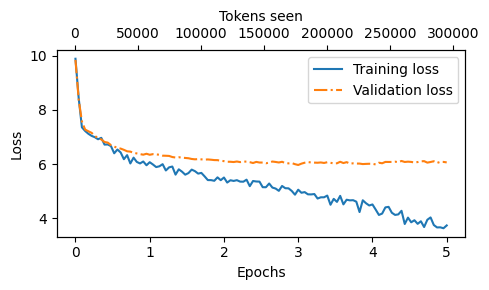

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)